In [1]:
# This file uses the inhouse qcbm code from the paper and compares MMD with MCR
import numpy as np
import matplotlib.pyplot as plt
import copy
import q_circuit as q # In house circuit code, to comare with Qiskit
import torch
import time
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
# Oh Hail the almighty Qiskit:
import qiskit
from qiskit import transpile, assemble
from qiskit.visualization import *
from qiskit import IBMQ
from qiskit.providers.jobstatus import JobStatus

# Import custom packages: These are written by me
import InHouse_Circuits as ihc
import Qiskit_Circuits as qkc
import Q_Generator as QG
import Q_Loss_and_Gradients as Q_gradients
import Utils
import Discriminator_Utils as D_utils # A file that contains different discriminator architectures
import time



In [2]:
from quspin.operators import hamiltonian,exp_op # Hamiltonians and operators
from quspin.basis import spin_basis_1d # Hilbert space spin basis
from quspin.tools.misc import KL_div
from scipy import integrate,optimize,special,stats,interpolate
import tensorflow as tf
import cv2

Debug against quspin exact diagonalization

In [3]:
# From Weishun's code
# disorder_m is a random array of lengh=n_qubit
def realization(H_XXZ,basis,disorder_m,h_disorder):
    #np.random.seed() # the random number needs to be seeded for each parallel process

	# compute disordered Hamiltonian
    unscaled_fields=-1+2*disorder_m
    h_z=[[unscaled_fields[i],i] for i in range(basis.L)]
    disorder_field = [["z",h_z]]    
    no_checks={"check_herm":False,"check_pcon":False,"check_symm":False}
    Hz=hamiltonian(disorder_field,[],basis=basis,dtype=np.float64,**no_checks)
    H_total=H_XXZ+h_disorder*Hz

    return H_total

def reduced_prob(psi_m):
    rho_v = basis.partial_trace(psi_m,sub_sys_A=tuple(range(L_visible)))
    probs = (np.diag(rho_v)/np.sum(np.diag(rho_v))).real
    return probs.astype('float')

In [4]:
#define simulation parameters
n_real=500 # number of disorder realisations to search over in each quench
n_M = int(100) #number of quenches/training steps
n_bins=20 #number of bins to use in level statistics
dataset = 'normal' #'MBL'
digit = 0
SEED = 42 #24

#define model parameters
L_visible = 4
L_hidden = 2
L = L_visible + L_hidden
basis = spin_basis_1d(L,pauli=False)
size = int(np.sqrt(2**(L_visible)))
N_visible = 2**L_visible

ti=0 #evolving initial time of each quench
tm = 1.0 #evolving final time of each quench
Jxy=1.0 # xy interaction
Jzz_0=1.0 # zz interaction at time t=0
h_d=20 #20.0 #0.1 #3.9 # disorder strength

bins_fixed = np.linspace(0,1,n_bins+1)

#=================set up Heisenberg Hamiltonian========================#

# define operators with PBC using site-coupling lists
J_zz = [[Jzz_0,i,(i+1)%L] for i in range(L)] # PBC
J_xy = [[Jxy/2.0,i,(i+1)%L] for i in range(L)] # PBC

# static and dynamic lists
static = [["+-",J_xy],["-+",J_xy],["zz",J_zz]]
dynamic = []

# compute the time-independent Heisenberg Hamiltonian
H_XXZ = hamiltonian(static,dynamic,basis=basis,dtype=np.float64)

Hermiticity check passed!


<ipython-input-4-51f5784e5b68>:36: UserWarning: Test for symmetries not implemented for <class 'quspin.basis.basis_1d.spin.spin_basis_1d'>, to turn off this warning set check_symm=False in hamiltonian
  H_XXZ = hamiltonian(static,dynamic,basis=basis,dtype=np.float64)


In [5]:
np.random.seed(SEED)
np.random.rand(L)

array([0.37454012, 0.95071431, 0.73199394, 0.59865848, 0.15601864,
       0.15599452])

In [6]:
np.random.rand(L)

array([0.05808361, 0.86617615, 0.60111501, 0.70807258, 0.02058449,
       0.96990985])

In [7]:
np.random.rand(L)

array([0.83244264, 0.21233911, 0.18182497, 0.18340451, 0.30424224,
       0.52475643])

In [5]:
#set up initial product state
ind_0 = basis.state_to_int('111000')
psi_0 = np.zeros([basis.Ns],dtype = 'complex_') 
psi_0[ind_0] = 1
psi_m = np.copy(psi_0) # state vector
h_disorder = 20

# evolve
np.random.seed(SEED)
disorder_m = np.random.rand(L)

H_total = realization(H_XXZ,basis,disorder_m,h_disorder)
psi_m = H_total.evolve(psi_m,ti,tm)

In [6]:
psi_m

array([ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j, -6.47819719e-07+7.59685138e-07j,
        0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j, -3.04896354e-06+1.74100747e-06j,
        0.00000000e+00+0.00000000e+00j,  7.89131939e-04+3.85321705e-04j,
        9.65924539e-05-1.59099854e-04j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,  2.62083516e-04+1.58749962e-04j,
        0.00000000e+00+0.00000000e+00j, -1.17578892e-02-9.46963256e-03j,
       -2.82640017e-03+1.76617332e-03j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,  2.11768359e-02+7.73749651e-02j,
        2.37791803e-02+1.22115713e-02j,  0.00000000

Try the same with symmetrized trotterization 

In [7]:
# try the same with my symmetrized trotterization 
connections = [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5,0)]
print('connection scheme', connections)
 
simulator = qiskit.Aer.get_backend('statevector_simulator')

# t_m is the duration of each quench temperature, one delta_t time corresponds to one
# There is no quenche layers set up when you first call the circuit initialization:
circuit0 = qkc.MBL_Circuit_quench(delta_t=0.01, t_m=1.0, Jxy=1.0, Jzz=1.0, 
                                  n_qubits=L, n_h_qubits=L_hidden, 
                                  connections=connections, backend=simulator)

connection scheme [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 0)]


In [8]:
psi_0

array([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j])

In [9]:
disorder_m # between 0 and 1

array([0.37454012, 0.95071431, 0.73199394, 0.59865848, 0.15601864,
       0.15599452])

In [10]:
circuit0.load_arbitrary_state(qiskit.quantum_info.Statevector(psi_0))
h_vec = torch.FloatTensor( (disorder_m*2-1)*h_disorder )
px, state = circuit0.pdf_actual( h_vec )

/Users/pengyuanzhai/Documents/MBL_Born/Qiskit_Circuits.py:248: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /tmp/pip-req-build-7w1l4mea/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.FloatTensor(probabilities), full_statevec
/Users/pengyuanzhai/Documents/MBL_Born/Qiskit_Circuits.py:248: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  /tmp/pip-req-build-7w1l4mea/aten/src/ATen/native/Copy.cpp:162.)
  return torch.FloatTensor(probabilities), full_statevec


Compare the two evolved states

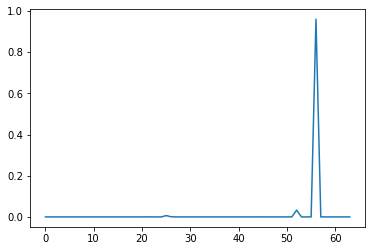

In [11]:
plt.plot(psi_m.real**2+psi_m.imag**2)

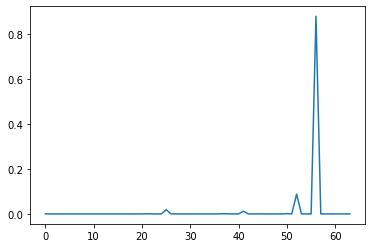

In [12]:
plt.plot(state.data.real**2+state.data.imag**2)

In [13]:
state.data-psi_m #-1.80304033e+00+8.52786475e-02j

array([ 0.00000000e+00+0.00000000e+00j,  1.30450656e-16+2.77218131e-16j,
        5.80334706e-17+3.59569795e-17j,  0.00000000e+00+0.00000000e+00j,
       -6.57839263e-17+2.35998486e-16j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j, -3.41477379e-05+4.21153182e-05j,
       -2.44548739e-16-1.41512228e-16j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,  7.56778027e-05+1.45897133e-04j,
        0.00000000e+00+0.00000000e+00j,  1.71938882e-04-3.89453164e-04j,
       -5.73151515e-05+1.74074718e-04j,  0.00000000e+00+0.00000000e+00j,
       -2.35064698e-16+7.34780685e-17j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,  2.52707246e-03-7.11167307e-04j,
        0.00000000e+00+0.00000000e+00j,  3.70397755e-02+9.07602936e-03j,
        3.75001058e-03-1.51679610e-03j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,  1.07565302e-01-1.24906870e-01j,
       -2.01664641e-02-1.46150143e-02j,  0.00000000

sum diff squared 1.245174148511996e-08


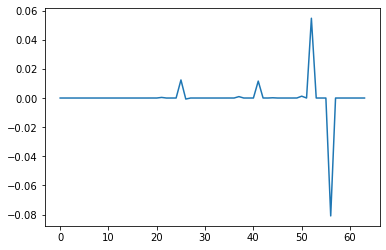

In [14]:
plt.plot(np.abs(state.data)**2-np.abs(psi_m)**2)
print('sum diff squared', sum(np.abs(state.data)**2-np.abs(psi_m)**2))

See what happens if we evolve again:

In [28]:
np.random.seed(SEED+3)
disorder_m = np.random.rand(L)
# evolve theoretical
H_total = realization(H_XXZ,basis,disorder_m,h_disorder)
psi_m = H_total.evolve(psi_m,ti,tm)

# eolve circuit
#circuit0.load_arbitrary_state(qiskit.quantum_info.Statevector(state.data))
circuit0.load_arbitrary_state(state)
h_vec = torch.FloatTensor( (disorder_m*2-1)*h_disorder )
px, state = circuit0.pdf_actual( h_vec )

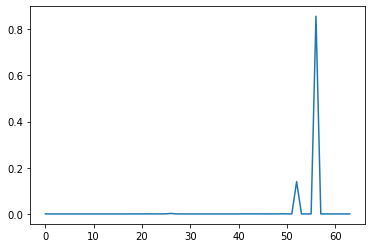

In [29]:
plt.plot(psi_m.real**2+psi_m.imag**2)

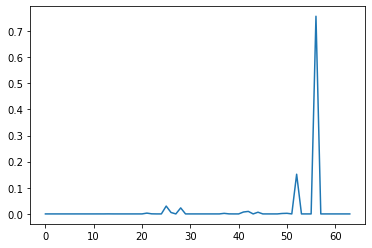

In [30]:
plt.plot(state.data.real**2+state.data.imag**2)

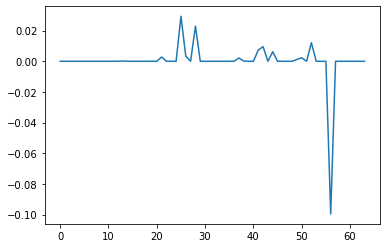

In [31]:
plt.plot(np.abs(state.data)**2-np.abs(psi_m)**2)

In [31]:
#======================================Start of Configurations=================================
n_qubits = 6 # We use 6 qubits, two hidden
n_h_qubits = 2
n_show_qubits = n_qubits-n_h_qubits
x_basis_m_n = torch.FloatTensor(Utils.binary_basis((n_show_qubits,))) 
sigma_list = [0.1,0.25,4,10]
K = Utils.mix_rbf_kernel(x_basis_m_n, x_basis_m_n, sigma_list)
connections = [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5,0)]
print('connection scheme', connections)
 
simulator = qiskit.Aer.get_backend('statevector_simulator')

# t_m is the duration of each quench temperature, one delta_t time corresponds to one
# There is no quenche layers set up when you first call the circuit initialization:
circuit0 = qkc.MBL_Circuit_quench(delta_t=0.05, t_m=1.0, Jxy=1.0, Jzz=1.0, 
                                  n_qubits=n_qubits, n_h_qubits=n_h_qubits, 
                                  connections=connections, backend=simulator)
circuit0._circuit.draw()

connection scheme [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 0)]


»
q_0: »
     »
q_1: »
     »
q_2: »
     »
q_3: »
     »
q_4: »
     »
q_5: »
     »
c: 4/»
     »
«     ┌──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐»
«q_0: ┤0                                                                                                                                             ├»
«     │                                                                                                                                              │»
«q_1: ┤1                                                                                                                                             ├»
«     │                                                                                                                                              │»
«q_2: ┤2                                                                                                                                             ├»
«     │  Initialize(1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0) │»
«q_3: ┤3                                                                                                                                             ├»
«     │                                                                                                                                              │»
«q_4: ┤4                                                                                                                                             ├»
«     │                                                                                                                                              │»
«q_5: ┤5                                                                                                                                             ├»
«     └──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘»
«c: 4/════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════»
«                                                                                                                                                     »
«     ┌──────────────┐┌────┐┌────┐┌────┐┌──────────────┐┌──────────────┐┌────┐»
«q_0: ┤ Rz(0.05*h_0) ├┤0   ├┤0   ├┤0   ├┤ Rz(0.05*h_0) ├┤ Rz(0.05*h_0) ├┤0   ├»
«     ├──────────────┤│    ││    ││    │├──────────────┤├──────────────┤│    │»
«q_1: ┤ Rz(0.05*h_1) ├┤1   ├┤1   ├┤1   ├┤ Rz(0.05*h_1) ├┤ Rz(0.05*h_1) ├┤1   ├»
«     ├──────────────┤│    ││    ││    │├──────────────┤├──────────────┤│    │»
«q_2: ┤ Rz(0.05*h_2) ├┤2   ├┤2   ├┤2   ├┤ Rz(0.05*h_2) ├┤ Rz(0.05*h_2) ├┤2   ├»
«     ├──────────────┤│  B ││  C ││  B │├──────────────┤├──────────────┤│  B │»
«q_3: ┤ Rz(0.05*h_3) ├┤3   ├┤3   ├┤3   ├┤ Rz(0.05*h_3) ├┤ Rz(0.05*h_3) ├┤3   ├»
«     ├──────────────┤│    ││    ││    │├──────────────┤├──────────────┤│    │»
«q_4: ┤ Rz(0.05*h_4) ├┤4   ├┤4   ├┤4   ├┤ Rz(0.05*h_4) ├┤ Rz(0.05*h_4) ├┤4   ├»
«     ├──────────────┤│    ││    ││    │├──────────────┤├──────────────┤│    │»
«q_5: ┤ Rz(0.05*h_5) ├┤5   ├┤5   ├┤5   ├┤ Rz(0.05*h_5) ├┤ Rz(0.05*h_5) ├┤5   ├»
«     └──────────────┘└────┘└────┘└────┘└──────────────┘└──────────────┘└────┘»
«c: 4/════════════════════════════════════════════════════════════════════════»
«                                                                             »
«     ┌────┐┌────┐┌──────────────┐┌──────────────┐┌────┐┌────┐┌────┐»
«q_0: ┤0   ├┤0   ├┤ Rz(0.05*h_0) ├┤ Rz(0.05*h_0) ├┤0   ├┤0   ├┤0   ├»
«     │    ││    │├──────────────┤├──────────────┤│    ││    ││    │»
«q_1: ┤1   ├┤1   ├┤ Rz(0.05*h_1) ├┤ Rz(0.05*h_1) ├┤1   ├┤1   ├┤1   ├»
«     │    ││    │├──────────────┤├──────────────┤│    ││    ││    │»
«q_2: ┤2   ├┤2   ├┤ Rz(0.05*h_2) ├┤ Rz(0.05*h_2) ├┤2   ├┤2   ├┤2   ├»


Text(0.5, 1.0, 'target distribution')

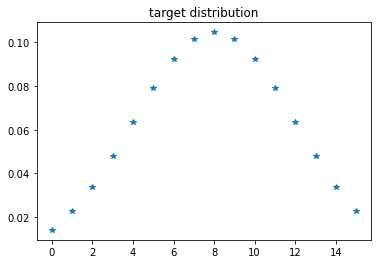

In [32]:
#======================================Create p_data==========================================
hdim = 2**n_show_qubits
p_data = torch.FloatTensor(Utils.gaussian_pdf((n_show_qubits,), hdim/2., hdim/4.))
plt.plot(p_data, '*')
plt.title('target distribution')


In [33]:
sum(p_data)

tensor(1.0000)

In [34]:
'1'*int(n_qubits/2)+'0'*int(n_qubits/2)

'111000'

Fast: training loop with saved statevector at each quench

In [35]:
M = 100 # Total number of quenches
n_branches = 500 # number of search branches at each quench
hd = 20 # Range of the randomly selected localization conef [-hd, +hd]
training_losses = [] # To record the best mmd out of all candidate points at each quench m
training_losses_th = []
# Prepare the initial domain wall state via statevec
state = qiskit.quantum_info.Statevector.from_label('1'*int(n_qubits/2)+'0'*int(n_qubits/2))
print('wallstate', state)
psi_m = state.data

wallstate Statevector([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j],
            dims=(2, 2, 2, 2, 2, 2))


Theoretical quench

In [36]:
states_th = []
probs_th = []
for m in range(M):
    t0 = time.time()

    # First randomly select candidate configurations of hz for quench m:
    
    mmds_theoretical= []
    
    disorder_m_array = []
    for b in range(n_branches):
        # Only randomly earch prameterse for this specific quench
        disorder_m = np.random.rand(n_qubits)
        #print('disorder_m', disorder_m)
        # theoretical:
        H_total = realization(H_XXZ, basis, disorder_m, hd)
        psi_m_candidate = H_total.evolve(psi_m, 0.0, 1.0)
        px_theoretical = reduced_prob(psi_m_candidate)
        
        disorder_m_array.append(disorder_m) # keep a record of this for debugging
        
        pxy = p_data-torch.FloatTensor(px_theoretical)
        mmd_distance_theoretical = pxy@K@(pxy.T)
        mmds_theoretical.append(mmd_distance_theoretical)
    
    # Select best:
    ind_theoretical = np.argmin(mmds_theoretical)
    print('ind_t, best theoretical mmd', (ind_theoretical, mmds_theoretical[ind_theoretical]) )
    
    
    training_losses.append(mmds_theoretical[ind_theoretical])
    # Recalculate the best evolved state for the next quench
    H_total = realization(H_XXZ, basis, disorder_m_array[ind_theoretical], hd)
    
    print('difference', sum(np.abs(psi_m)-np.abs(H_total.evolve(psi_m, 0.0, 1.0))) )
    psi_m = H_total.evolve(psi_m, 0.0, 1.0)
    px_theoretical = reduced_prob(psi_m)
    
    states_th.append(psi_m)
    probs_th.append(px_theoretical)
    t1 = time.time()
    print('time', t1-t0)

ind_t, best theoretical mmd (271, tensor(0.9186))
difference -1.049943654246845
time 3.9855799674987793
ind_t, best theoretical mmd (462, tensor(0.3262))
difference -0.612558875261004
time 4.455725908279419
ind_t, best theoretical mmd (197, tensor(0.1722))
difference -1.1236291820271154
time 5.271892309188843
ind_t, best theoretical mmd (49, tensor(0.0788))
difference -0.17988994124376048
time 4.726837158203125
ind_t, best theoretical mmd (445, tensor(0.0636))
difference -0.07657590137440601
time 4.856616258621216
ind_t, best theoretical mmd (227, tensor(0.0437))
difference -0.11395734814640567
time 4.790410041809082
ind_t, best theoretical mmd (399, tensor(0.0378))
difference -0.005817065793234946
time 4.760508060455322
ind_t, best theoretical mmd (114, tensor(0.0275))
difference -0.0294471158157973
time 4.764832973480225
ind_t, best theoretical mmd (491, tensor(0.0192))
difference -0.03127439927074842
time 4.644129037857056
ind_t, best theoretical mmd (341, tensor(0.0122))
difference

ind_t, best theoretical mmd (240, tensor(0.0018))
difference 0.008235898495216644
time 5.164157867431641
ind_t, best theoretical mmd (17, tensor(0.0019))
difference -0.0013308859391218432
time 4.801113128662109
ind_t, best theoretical mmd (55, tensor(0.0019))
difference -0.1624302792187839
time 4.92924427986145
ind_t, best theoretical mmd (429, tensor(0.0018))
difference 0.005307279686615443
time 4.896260976791382
ind_t, best theoretical mmd (473, tensor(0.0021))
difference -0.019439974020606543
time 4.817888021469116
ind_t, best theoretical mmd (491, tensor(0.0020))
difference 0.0008574979763167068
time 5.2786571979522705
ind_t, best theoretical mmd (55, tensor(0.0019))
difference 0.018330543851865003
time 5.093234300613403
ind_t, best theoretical mmd (79, tensor(0.0018))
difference 0.0022412008236305046
time 4.960825204849243
ind_t, best theoretical mmd (228, tensor(0.0021))
difference -0.011878066716844653
time 4.980525970458984
ind_t, best theoretical mmd (181, tensor(0.0020))
diff

Text(0.5, 1.0, 'px of MBL with exact diag last quench m')

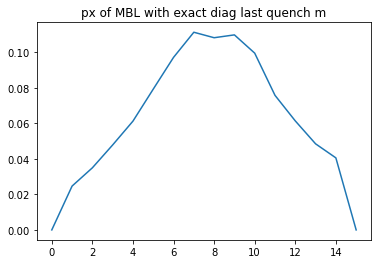

In [38]:
plt.plot(px_theoretical)
plt.title('px of MBL with exact diag last quench m')

Circuit trotterization quench

In [21]:
states = []
probs = []
for m in range(M):
    t0 = time.time()
    # load the state from previous quench
    circuit0.load_arbitrary_state(state)
    
    # First randomly select candidate configurations of hz for quench m:
    mmds = []
    mmds_theoretical= []
    
    theta_list_array = []
    for b in range(n_branches):
        # Only randomly earch prameterse for this specific quench
        disorder_m = np.random.rand(n_qubits)
        
        theta_list_m = torch.FloatTensor( (disorder_m*2-1)*hd )
        # use these parameters 
        px, _ = circuit0.pdf_actual(theta_list_m)
        
        pxy = p_data-px
        mmd_distance = pxy@K@(pxy.T)
        mmds.append(mmd_distance)
        theta_list_array.append(theta_list_m) # keep a record of this for debugging
    
    ind = np.argmin(mmds)
    print('ind, best mmd', (ind, mmds[ind]))
    
    training_losses_th.append(mmds[ind])
    # Recalculate the best evolved state for the next quench
    px, state = circuit0.pdf_actual(theta_list_array[ind]) # returns a StateVector object
    states.append(state)
    probs.append(px)
    t1 = time.time()
    print('time', t1-t0)

ind, best mmd (48, tensor(0.2857))
time 51.10447907447815
ind, best mmd (202, tensor(0.0999))
time 48.66359186172485
ind, best mmd (85, tensor(0.0505))
time 48.1865508556366
ind, best mmd (293, tensor(0.0403))
time 48.25761103630066
ind, best mmd (214, tensor(0.0291))
time 47.17266607284546
ind, best mmd (456, tensor(0.0197))
time 48.15145993232727
ind, best mmd (144, tensor(0.0109))
time 48.87608599662781
ind, best mmd (84, tensor(0.0098))
time 47.869433879852295
ind, best mmd (290, tensor(0.0059))
time 49.637941122055054
ind, best mmd (312, tensor(0.0056))
time 48.74694776535034
ind, best mmd (299, tensor(0.0067))
time 49.97511386871338
ind, best mmd (380, tensor(0.0059))
time 50.17441701889038
ind, best mmd (262, tensor(0.0056))
time 47.98753309249878
ind, best mmd (171, tensor(0.0054))
time 48.08664393424988
ind, best mmd (67, tensor(0.0049))
time 48.702940225601196
ind, best mmd (394, tensor(0.0049))
time 49.234007120132446
ind, best mmd (186, tensor(0.0046))
time 48.0492849349975

Text(0.5, 1.0, 'px of MBL with symmetrized trotterization last quench m')

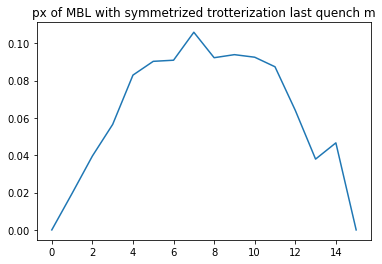

In [28]:
plt.plot(px)
plt.title('px of MBL with symmetrized trotterization last quench m')

Text(0.5, 1.0, 'px of MBL with symmetrized trotterization best over all (quench 53')

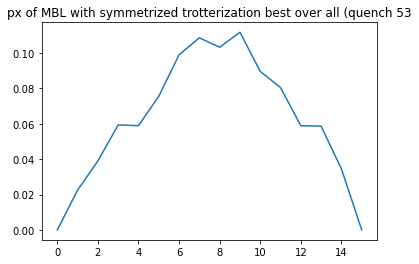

In [30]:
ind = np.argmin(training_losses)

plt.plot(probs[ind])
plt.title('px of MBL with symmetrized trotterization best over all (quench '+str(ind))

Text(0.5, 1.0, 'MBL with symmetrized trotterization')

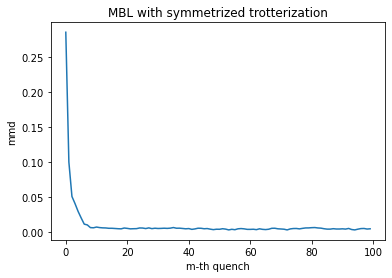

In [25]:
plt.plot(training_losses)
plt.xlabel('m-th quench')
plt.ylabel('mmd')
plt.title('MBL with symmetrized trotterization')

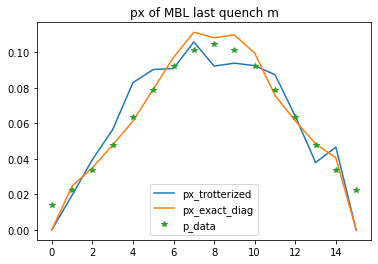

In [41]:
plt.plot(px)
plt.plot(px_theoretical)
plt.plot(p_data, '*')
plt.title('px of MBL last quench m')
plt.legend(['px_trotterized', 'px_exact_diag', 'p_data'])

In [46]:
px

tensor([1.0527e-29, 1.9547e-02, 3.9552e-02, 5.6491e-02, 8.2900e-02, 9.0276e-02,
        9.0876e-02, 1.0586e-01, 9.2217e-02, 9.3854e-02, 9.2484e-02, 8.7366e-02,
        6.4042e-02, 3.7921e-02, 4.6618e-02, 1.7663e-30])

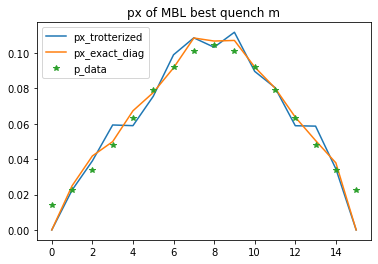

In [47]:
plt.plot(probs[53])
plt.plot(probs_th[np.argmin(training_losses)])
plt.plot(p_data, '*')
plt.title('px of MBL best quench m')
plt.legend(['px_trotterized', 'px_exact_diag', 'p_data'])

Text(0.5, 1.0, 'MBL with exact diag')

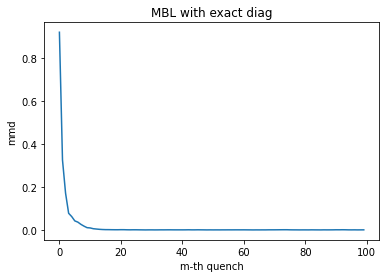

In [48]:
plt.plot(training_losses)
plt.xlabel('m-th quench')
plt.ylabel('mmd')
plt.title('MBL with exact diag')

Comparison Quench

In [19]:
states = []
probs = []
for m in range(M):
    t0 = time.time()
    # load the state from previous quench
    circuit0.load_arbitrary_state(state)
    
    # First randomly select candidate configurations of hz for quench m:
    mmds = []
    mmds_theoretical= []
    
    theta_list_array = []
    for b in range(n_branches):
        # Only randomly earch prameterse for this specific quench
        disorder_m = np.random.rand(n_qubits)
        
        theta_list_m = torch.FloatTensor( (disorder_m*2-1)*hd )
        # use these parameters 
        px, _ = circuit0.pdf_actual(theta_list_m)
        
        
        # theoretical:
        H_total = realization(H_XXZ, basis, disorder_m, hd)
        psi_m = H_total.evolve(state.data, 0.0, 1.0)
        px_theoretical = reduced_prob(psi_m)
        
        pxy = p_data-px
        mmd_distance = pxy@K@(pxy.T)
        mmds.append(mmd_distance)
        theta_list_array.append(theta_list_m) # keep a record of this for debugging
        
        pxy_th = p_data-torch.FloatTensor(px_theoretical)
        mmd_distance_theoretical = pxy_th@K@(pxy_th.T)
        mmds_theoretical.append(mmd_distance_theoretical)
    
    ind = np.argmin(mmds)
    print('ind, best mmd', (ind, mmds[ind]))
    ind_theoretical = np.argmin(mmds_theoretical)
    print('ind_t, best theoretical mmd', (ind_theoretical, mmds_theoretical[ind_theoretical]) )
    
    
    training_losses.append(mmds[ind])
    # Recalculate the best evolved state for the next quench
    px, state = circuit0.pdf_actual(theta_list_array[ind]) # returns a StateVector object
    states.append(state)
    probs.append(px)
    t1 = time.time()
    print('time', t1-t0)

ind, best mmd (0, tensor(1.9249))
ind_t, best theoretical mmd (3, tensor(1.8117))
time 2.142482280731201
ind, best mmd (4, tensor(1.8976))
ind_t, best theoretical mmd (1, tensor(1.8336))
time 1.9627659320831299
ind, best mmd (3, tensor(1.8895))
ind_t, best theoretical mmd (3, tensor(1.8730))
time 2.0062568187713623
ind, best mmd (2, tensor(1.8677))
ind_t, best theoretical mmd (3, tensor(1.8803))
time 1.8696379661560059
ind, best mmd (2, tensor(1.8561))
ind_t, best theoretical mmd (3, tensor(1.8659))
time 1.9901020526885986
ind, best mmd (3, tensor(1.8464))
ind_t, best theoretical mmd (1, tensor(1.8637))
time 1.7963640689849854
ind, best mmd (2, tensor(1.8410))
ind_t, best theoretical mmd (1, tensor(1.8800))
time 1.8186419010162354
ind, best mmd (3, tensor(1.8426))
ind_t, best theoretical mmd (2, tensor(1.8763))
time 1.9734299182891846
ind, best mmd (0, tensor(1.8378))
ind_t, best theoretical mmd (0, tensor(1.8732))
time 1.8174610137939453
ind, best mmd (0, tensor(1.8368))
ind_t, best t

KeyboardInterrupt: 

In [ ]:
plt.plot(probs[0])

In [ ]:
plt.plot(probs[1])

In [ ]:
plt.plot(probs[2])

In [ ]:
plt.plot(states[0].data)

In [ ]:
plt.plot(states[1].data)

In [ ]:
plt.plot(states[2].data)

In [ ]:
plt.plot(states[5].data)

In [ ]:
circuit0.thetas

In [ ]:
phi = qiskit.circuit.Parameter('phi')
phi2 = qiskit.circuit.Parameter('phi')
qc = qiskit.QuantumCircuit(1)
print('qc first praemeter', qc._parameter_table)
# parameterize the rotation
qc.rx(phi, 0)
print(qc.data)
qc.draw()

# bind the parameters after circuit to create a bound circuit
bc = qc.bind_parameters({phi: 3.14})
bc.measure_all()
bc.draw()
qc.rx(phi,0)
qc.rx(phi,0)



In [ ]:
A = []
theta = qiskit.circuit.Parameter('t')
A.append(theta)

In [ ]:
theta in A

In [ ]:
theta1 = qiskit.circuit.Parameter('t')
theta1 in A

In [ ]:
theta2 = copy.deepcopy(theta)
theta2 in A

In [ ]:
id(theta2)

In [ ]:
id(theta)

In [ ]:
id(theta1)

In [ ]:
theta2.name='new-t'

In [ ]:
qc._parameter_table

phi5 = copy.deepcopy(phi4)

In [ ]:
phi5 in qc._parameter_table

In [ ]:
phi3=phi# pass by reference
import copy
phi4=copy.deepcopy(phi)
qc.rx(phi4,0)# meaning that qiskist doesn't detect parameter duplicatres via address

In [ ]:
psi0=qiskit.circuit.Parameter('psi0')
qc._update_parameter_table(qc.data[0][0])

In [ ]:
qc.rx(phi2,0)

In [ ]:
qc.data

In [ ]:
phi4==phi

In [ ]:
phi.parameters

In [ ]:
qc.rx(phi2,0)

In [ ]:
qc._parameter_table.clear()

In [ ]:
qc.rx(phi2,0)

In [ ]:
circuit0._circuit.data

In [ ]:
circuit0._circuit.draw()

In [ ]:
torch.cat([torch.Tensor(), torch.zeros((3))])

In [ ]:
torch.ones(3)@torch.ones((3,3))@torch.ones(3)

In [ ]:
(torch.rand( (circuit0.current_m+1)*circuit0.n_qubits )*2-1)*1.8